#### Цель работы
Изучение алгоритмов и методов кластеризации на практике

#### Описание предметной области
Вариант: 3 <br>
Набор данных: ecommerce_fraud.csv
- **transaction_amount** — сумма транзакции, USD, числовой (логнормальное
распределение, возможны крупные суммы).
- **device_type** — тип устройства: Desktop / Mobile / Tablet, категориальный.
- **browser** — браузер: Chrome / Safari / Firefox / Edge / Other, категориальный.
- **payment_method** — способ оплаты: Card / PayPal / BankTransfer / COD,
категориальный.
- **country** — страна покупателя: US / UK / DE / FR / IN / BR / CN / Other,
категориальный.
- **num_items** — количество товаров в заказе, целочисленный (1–7).
- **time_on_site_sec** — время на сайте до покупки, секунды, числовой.
- **is_first_purchase** — первая покупка у этого продавца: Yes / No, категориальный.
- **referral** — источник трафика: Direct / Search / Social / Ads, категориальный.
- **hour_of_day** — час суток оформления заказа (0–23), целочисленный.
- **account_age_days** — «возраст» аккаунта, в днях, числовой.
- **Fraud** — целевой класс: 1 — мошенническая транзакция, 0 — нормальная

#### Часть 1

Функция `make_data` создаёт набор данных для кластеризации. <br> Параметры: <br> 
- `n` — количество объектов в каждой группы (всего 3 группы).
- `seed` — «зерно» для генератора случайных чисел, чтобы результаты были воспроизводимыми. 

In [2]:
import numpy as np
import pandas as pd

def make_data(n, seed):
    np.random.seed(seed)
    
    shift_matrix = np.array([[3, 3], 
                            [6, 9],
                            [9, 3]])
    
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    
    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
    columns=['x', 'y'])
    df = df.sample(frac=1.0)
    
    return df

---

Код задаёт параметры генерации данных, вызывает функцию make_data, которая создаёт синтетический набор с тремя группами и двумя признаками x и y, сохраняет результат в DataFrame df, метод head() выводит первые пять строк для быстрой проверки, а shape показывает размер набора данных
- `n = 50` — задаёт количество объектов в каждой группы, которые будут сгенерированы функцией `make_data`. <br>
  Так как всего 3 группы, итоговый размер набора будет `3 * n = 150` объектов.
- `seed = 42` — это «зерно» генератора случайных чисел. <br>
  Оно позволяет воспроизводить случайные данные: при одном и том же seed функция будет создавать одинаковые значения.

In [3]:
# Выбор параметров
n = 50
seed = 42

# Генерация набора данных
df = make_data(n, seed)

# Просмотр первых строк
print(df.head())

# Размер набора данных (ожидается 3*n строк)
print("Размер:", df.shape)

             x         y
33   38.845781  1.240865
23   31.505036  2.282322
50   91.692585  4.625246
63  169.264842  4.089659
88  136.270344  4.076603
Размер: (150, 2)


Вывод показывает результат работы функции `make_data` для генерации синтетических данных.
- Таблица с колонками `x` и `y` представляет первые пять объектов набора данных (метод `head()`): каждая строка — один объект с координатами признаков `x` и `y`.
- Значения `x` и `y` — это случайные числа, сгенерированные вокруг центров трёх групп с учётом смещений и масштабирования, поэтому они отличаются между собой.
- Размер: (150, 2) показывает, что всего в наборе 150 объектов (3 группы по 50 объектов) и 2 признака на каждый объект, что соответствует ожидаемому результату.

---

Этот код выполняет стандартизацию признаков набора данных для дальнейшего анализа или кластеризации.
Сначала выбираются признаки `x` и `y` из DataFrame `df` и сохраняются в переменной `X`. <br> Затем создаётся объект `StandardScaler` из библиотеки `sklearn`, который предназначен для преобразования данных так, чтобы каждый признак имел среднее значение 0 и стандартное отклонение 1. Метод `fit(X)` обучает стандартизатор на данных, а `transform(X)` выполняет само преобразование. <br> Результат сохраняется в массив `X_scaled`, который затем преобразуется обратно в DataFrame `df_scaled` с теми же названиями колонок для удобства анализа. Метод `head()` выводит первые пять строк стандартизированных данных, чтобы убедиться, что преобразование выполнено корректно.

In [4]:
from sklearn.preprocessing import StandardScaler

X = df[['x', 'y']]     # выбор признаков
scaler = StandardScaler()

scaler.fit(X)          # обучение стандартизатора
X_scaled = scaler.transform(X)   # преобразование данных

df_scaled = pd.DataFrame(X_scaled, columns=['x', 'y'])
print(df_scaled.head())


          x         y
0 -1.440459 -0.842663
1 -1.571984 -0.153027
2 -0.493596  1.398419
3  0.896277  1.043762
4  0.305110  1.035116


Вывод показывает первые пять строк стандартизированных данных после применения StandardScaler.
- Каждое значение в колонках `x` и `y` теперь представляет собой отклонение от среднего в единицах стандартного отклонения: <br>
Отрицательные значения → ниже среднего по признаку <br>
Положительные значения → выше среднего по признаку
- Например, `x` = -1.44 означает, что первый объект имеет значение признака x, примерно на 1.44 стандартного отклонения ниже среднего.
- Аналогично для `y`.

---

Код выполняет кластеризацию методом `KMeans`. Создаётся объект `KMeans` с 3 кластерами и фиксированным `random_state` для воспроизводимости. Метод `fit_predict(df_scaled)` одновременно обучает модель на стандартизированных данных и присваивает каждому объекту метку кластера. `labels[:10]` выводит первые 10 меток для проверки результатов.

In [5]:
from sklearn.cluster import KMeans

# Обучение модели и получение меток кластеров
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df_scaled)

print(labels[:10])   # вывод первых 10 меток


[2 2 0 0 0 0 0 2 0 2]


Этот вывод [2 2 0 0 0 0 0 2 0 2] показывает **первые 10 меток кластеров**, присвоенные объектам методом KMeans.
- Каждое число — это номер кластера, к которому отнесён соответствующий объект.
- Например, `2` означает, что объект попал в третий кластер, `0` — в первый, и так далее.

---

Код строит визуализацию результатов кластеризации `KMeans`. Сначала берутся стандартизированные признаки `x` и `y` в виде массива `X` для удобства работы. Затем получаются координаты центров кластеров из модели `KMeans` в переменной centers. Создаётся график заданного размера, для каждого кластера выбирается свой цвет, и с помощью цикла объекты каждого кластера отображаются на диаграмме рассеяния (scatter). После этого на графике отмечаются центры кластеров чёрными крестиками, чтобы показать их положение относительно объектов. Наконец, добавляются подписи осей, заголовок и легенда, и график отображается с помощью `plt.show()`

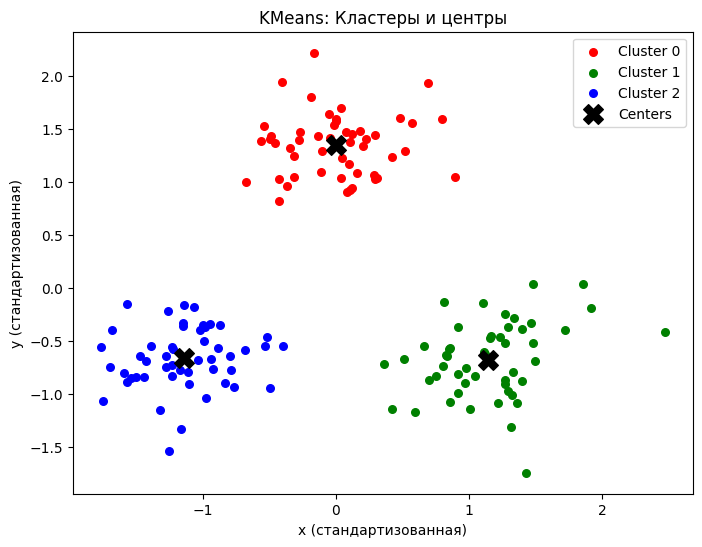

In [6]:
import matplotlib.pyplot as plt

# Получаем массив признаков для удобства
X = df_scaled[['x', 'y']].values

# Центры кластеров
centers = kmeans.cluster_centers_

# Создаём график
plt.figure(figsize=(8, 6))

# Цвета для кластеров
colors = ['red', 'green', 'blue']

# Рисуем объекты каждого кластера
for i in range(3):
    plt.scatter(
        X[labels == i, 0], 
        X[labels == i, 1], 
        s=30, 
        color=colors[i], 
        label=f'Cluster {i}'
    )

# Рисуем центры кластеров
plt.scatter(
    centers[:, 0], 
    centers[:, 1], 
    s=200, 
    marker='X', 
    color='black', 
    label='Centers'
)

# Подписи и легенда
plt.xlabel('x (стандартизованная)')
plt.ylabel('y (стандартизованная)')
plt.title('KMeans: Кластеры и центры')
plt.legend()
plt.show()


---

Код вычисляет коэффициент силуэта для кластеризации KMeans.
- В функцию `silhouette_score` передаются стандартизированные признаки `df_scaled` и метки кластеров `labels`.
- Коэффициент силуэта показывает, насколько объекты внутри кластера похожи друг на друга и насколько отделены от других кластеров.
- Метод возвращает число от `-1` до `1`: чем ближе к `1`, тем лучше выделены кластеры.

In [26]:
from sklearn.metrics import silhouette_score

# X — стандартизованные признаки, labels — метки кластеров
score = silhouette_score(df_scaled, labels)

print("Коэффициент силуэта:", score)


Коэффициент силуэта: 0.08562852542927651


По коэффициенту можно сделать вывод, что:
- Кластеры чётко выражены — объекты внутри каждого кластера похожи друг на друга, а кластеры хорошо отделены друг от друга.
- Значение близко к `1` указывает на высокое качество кластеризации.
- Это значит, что выбранное число кластеров и стандартизация признаков позволяют алгоритму `KMeans` эффективно разделить данные на группы.

---

Код выполняет кластеризацию методом `KMeans` для двух вариантов числа кластеров (2 и 4), вычисляет коэффициент силуэта для оценки качества кластеризации и строит визуализацию полученных кластеров. Для каждого числа кластеров создаётся модель `KMeans`, обучается на стандартизированных данных `df_scaled` и присваиваются метки объектов. Затем с помощью `silhouette_score` вычисляется показатель качества кластеризации, который выводится на экран. Далее на графике отображаются объекты каждого кластера разными цветами и центры кластеров чёрными крестиками, добавляются подписи осей, заголовок и легенда, после чего график отображается с помощью `plt.show()`

n_clusters = 2, Коэффициент силуэта: 0.486


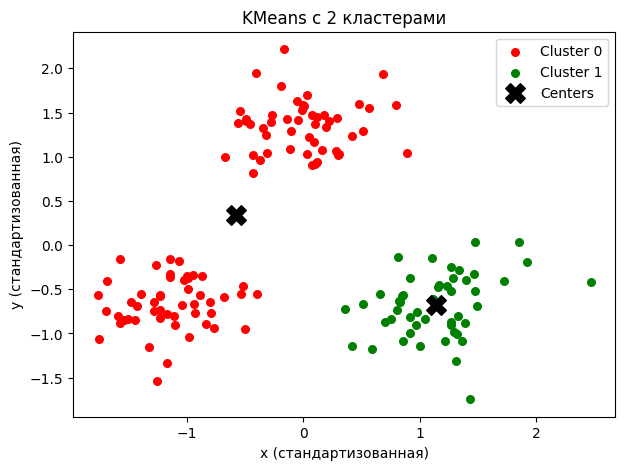

n_clusters = 4, Коэффициент силуэта: 0.588


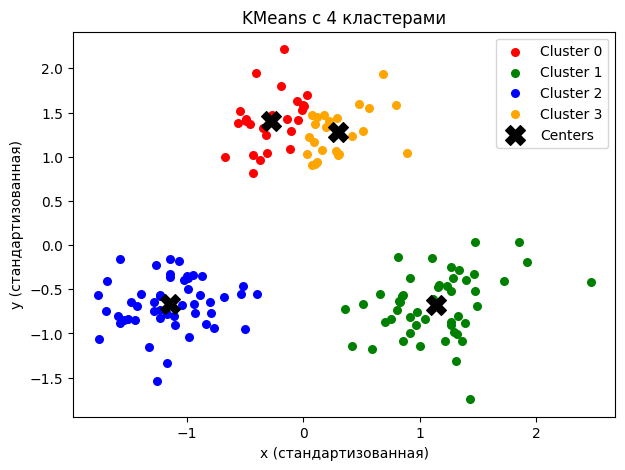

In [8]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

for n_clusters in [2, 4]:
    # Обучение KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    
    # Расчёт коэффициента силуэта
    score = silhouette_score(df_scaled, labels)
    print(f"n_clusters = {n_clusters}, Коэффициент силуэта: {score:.3f}")
    
    # Визуализация
    centers = kmeans.cluster_centers_
    plt.figure(figsize=(7,5))
    
    colors = ['red', 'green', 'blue', 'orange']  # на случай 4 кластеров
    
    for i in range(n_clusters):
        plt.scatter(
            df_scaled.values[labels == i, 0],
            df_scaled.values[labels == i, 1],
            s=30,
            color=colors[i],
            label=f'Cluster {i}'
        )
    
    plt.scatter(centers[:, 0], centers[:, 1],
                s=200, marker='X', color='black', label='Centers')
    
    plt.xlabel('x (стандартизованная)')
    plt.ylabel('y (стандартизованная)')
    plt.title(f'KMeans с {n_clusters} кластерами')
    plt.legend()
    plt.show()


Вывод по этим значениям:
- Для `n_clusters = 2` коэффициент силуэта равен `0.486`, что говорит о среднем качестве кластеризации: кластеры относительно различимы, но объекты внутри них не очень плотные и частично пересекаются.
- Для `n_clusters = 4` коэффициент силуэта увеличился до `0.588`, что указывает на лучшее разделение и более плотные кластеры, чем при двух группах.

---

#### Часть 2

Код загружает и первично исследует набор данных. Сначала с помощью `pd.read_csv()` считывается CSV-файл `ecommerce_fraud.csv` в DataFrame `df`. Метод `head()` выводит первые пять строк, чтобы быстро посмотреть, как выглядят данные и какие признаки присутствуют. Метод `info()` показывает общую информацию о DataFrame: количество строк, типы данных каждого столбца и наличие пропусков. Метод `describe()` рассчитывает статистическую сводку для числовых признаков: количество ненулевых значений, среднее, стандартное отклонение, минимальные, максимальные значения и квартильные показатели, что позволяет оценить распределение и масштаб данных перед дальнейшим анализом или кластеризацией.

In [29]:
import pandas as pd

# Загрузка данных
df = pd.read_csv(r'C://ГУАП/5 семестр/ВвАД/LR4/ecommerce_fraud.csv')

# Просмотр первых строк
print(df.head())

# Общая информация о датасете
print(df.info())
print(df.describe())


   transaction_amount device_type browser payment_method country  num_items  \
0               62.18     Desktop  Safari            COD      UK          3   
1               28.16     Desktop  Chrome            COD      US          2   
2               17.57      Mobile  Chrome           Card      DE          1   
3               61.61     Desktop  Safari         PayPal   Other          4   
4                4.28     Desktop    Edge           Card      BR          7   

   time_on_site_sec is_first_purchase referral  hour_of_day  account_age_days  \
0              58.0                No   Direct           15               808   
1              75.0               Yes   Direct           10               753   
2             101.0                No   Social           21              1017   
3              63.0               Yes   Search           20              1146   
4             399.0                No   Direct            4              1134   

   Fraud  
0      0  
1      0  
2    

---

Код выполняет проверку и очистку данных.
Сначала `df.isnull().sum()` подсчитывает количество пропущенных значений в каждом столбце DataFrame, что позволяет убедиться, что данных нет или выявить отсутствующие значения. Затем `df.drop_duplicates()` удаляет повторяющиеся строки, чтобы каждая запись в наборе данных была уникальной, предотвращая искажение анализа или кластеризации из-за дубликатов.

In [30]:
print(df.isnull().sum())
df = df.drop_duplicates()


transaction_amount    0
device_type           0
browser               0
payment_method        0
country               0
num_items             0
time_on_site_sec      0
is_first_purchase     0
referral              0
hour_of_day           0
account_age_days      0
Fraud                 0
dtype: int64


Вывод показывает, что все столбцы полностью заполнены, пропущенных значений нет

---

Код выполняет кодирование категориальных признаков для дальнейшего анализа или применения моделей машинного обучения.
- Сначала создаётся список категориальных столбцов `categorical_cols`.
- Затем функция pd.get_dummies() преобразует каждый категориальный признак в несколько бинарных (0/1) колонок — дамми-переменные, где каждая колонка соответствует одному из значений признака.
- Параметр `drop_first=True` исключает первый вариант каждого признака, чтобы избежать мультиколлинеарности при использовании в моделях.
- Результат сохраняется в `df_encoded`, который теперь содержит только числовые признаки и закодированные категориальные признаки, готовые для кластеризации или других алгоритмов.

In [31]:
categorical_cols = ['device_type', 'browser', 'payment_method', 
                    'country', 'is_first_purchase', 'referral']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


---

Эта строка создаёт список числовых признаков `numeric_cols`, которые будут использоваться для дальнейшей обработки данных, например, для стандартизации, нормализации или кластеризации. Список включает суммы транзакций, количество товаров, время на сайте, час оформления заказа и возраст аккаунта, то есть все количественные признаки, на которых можно выполнять математические операции и рассчитывать метрики расстояний.

In [32]:
numeric_cols = ['transaction_amount', 'num_items', 'time_on_site_sec', 
                'hour_of_day', 'account_age_days']


---

Этот код строит матрицу диаграмм рассеяния (pairplot) для числовых признаков с помощью библиотеки Seaborn.
- `numeric_cols + ['Fraud']` задаёт признаки, которые будут отображены на графиках, включая целевую переменную Fraud.
- Параметр hue='Fraud' окрашивает точки в зависимости от того, является ли транзакция мошеннической или нет, позволяя визуально оценить различия между классами.
- `diag_kind='kde'` строит на диагонали графики плотности распределения признаков, а corner=True отображает только нижний треугольник матрицы для компактности.
- `plt.show()` выводит график.

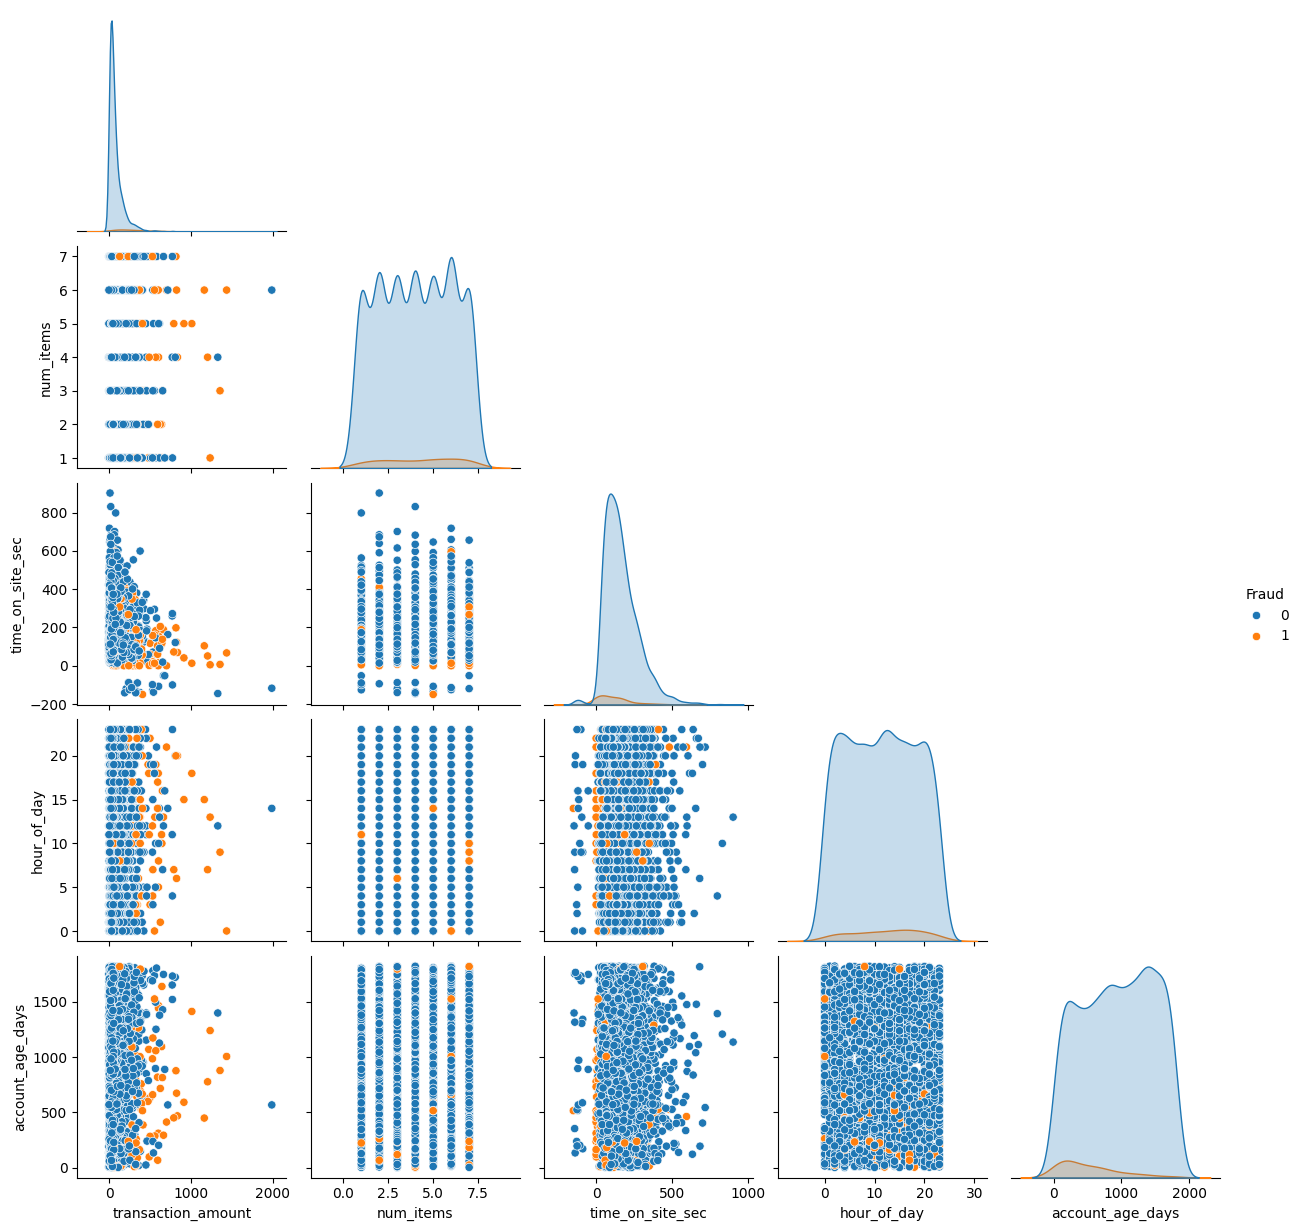

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Целевая переменная
y = df['Fraud']

# Строим pairplot для числовых признаков, окрашивая по Fraud
sns.pairplot(df[numeric_cols + ['Fraud']], hue='Fraud', diag_kind='kde', corner=True)
plt.show()


---

Код выполняет стандартизацию числовых признаков для подготовки данных к кластеризации или другим алгоритмам машинного обучения.
Сначала создаётся объект `StandardScale`r, который преобразует данные так, чтобы каждый признак имел среднее `0` и стандартное отклонение `1`.
Создаётся копия `df_encoded в df_scaled`, чтобы не изменять исходный DataFrame.
Метод `fit_transform` применяется только к числовым признакам из списка `numeric_cols`, после чего их значения заменяются стандартизированными в `df_scaled`.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


---

Код выполняет подбор оптимального числа кластеров для KMeans с помощью метода локтя и анализа коэффициента силуэта.
- Создаются два списка: `inertia` для хранения суммы квадратов расстояний объектов до центров кластеров и `sil_scores` для хранения коэффициента силуэта.
- В цикле for k in range(2, 10) создаются модели KMeans с разным числом кластеров от `2` до `9`, обучаются на стандартизированных признаках (без целевой переменной Fraud) и вычисляются соответствующие метрики.
- `inertia` отражает внутрикластерное рассеяние: чем меньше, тем плотнее кластеры. Метод локтя помогает визуально определить число кластеров, после которого дальнейшее уменьшение инерции незначительно.
- `sil_scores` показывает качество кластеризации: как хорошо объекты сгруппированы и отделены друг от друга, значения ближе к `1` — лучше.
- Далее строятся два графика: первый — метод локтя по `inertia`, второй — коэффициент силуэта для каждого `k`, что позволяет визуально выбрать оптимальное число кластеров для последующей кластеризации.

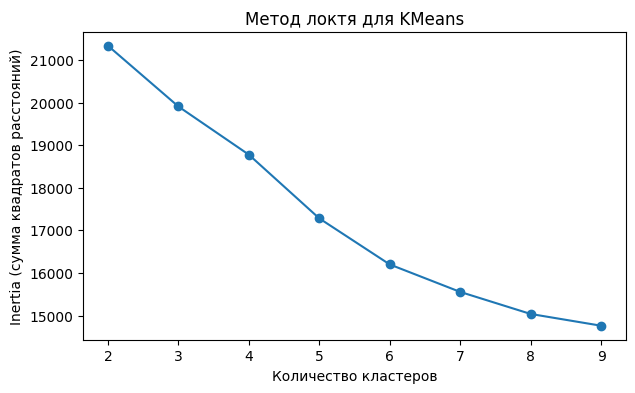

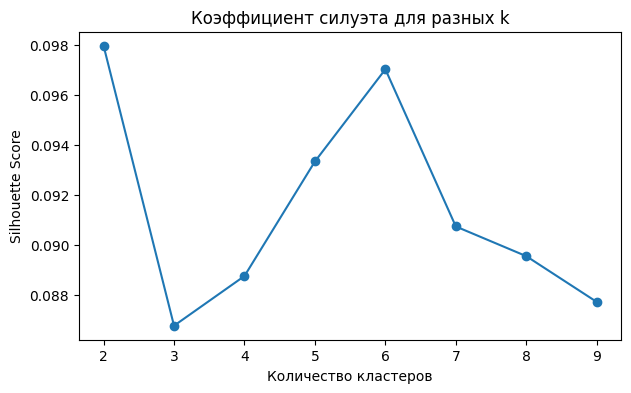

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled.drop('Fraud', axis=1))
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled.drop('Fraud', axis=1), labels))

# График метода локтя
plt.figure(figsize=(7,4))
plt.plot(range(2,10), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia (сумма квадратов расстояний)')
plt.title('Метод локтя для KMeans')
plt.show()

# График силуэта
plt.figure(figsize=(7,4))
plt.plot(range(2,10), sil_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта для разных k')
plt.show()


---

Код выполняет кластеризацию KMeans с выбранным оптимальным числом кластеров.
- `k_opt = 3` задаёт число кластеров, определённое на основании метода локтя или анализа коэффициента силуэта.
- Создаётся модель KMeans с этим числом кластеров и фиксированным `random_state` для воспроизводимости.
- Метод `fit_predict` обучает модель на стандартизированных признаках (без целевой переменной Fraud) и одновременно присваивает каждому объекту метку кластера.
- Результат сохраняется в новом столбце `cluster` DataFrame `df_scaled`, что позволяет дальше анализировать объекты по кластерам и вычислять их средние характеристики.

In [17]:
k_opt = 3  # пример
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled.drop('Fraud', axis=1))


---

Код выполняет анализ полученных кластеров.
- `df_scaled.groupby('cluster').mean()` группирует данные по меткам кластеров, присвоенным KMeans, и вычисляет средние значения всех признаков для каждого кластера.
- Результат сохраняется в `cluster_summary` и показывает, какие характеристики присущи каждому кластеру: средняя сумма транзакции, количество товаров, время на сайте, а также средние значения закодированных категориальных признаков.

In [18]:
cluster_summary = df_scaled.groupby('cluster').mean()
print(cluster_summary)


         transaction_amount  num_items  time_on_site_sec  hour_of_day  \
cluster                                                                 
0                 -0.038181   0.642008          0.080667     0.065831   
1                  0.081175   0.655909         -0.123504     0.049837   
2                 -0.033403  -1.045587          0.032398    -0.093360   

         account_age_days     Fraud  device_type_Mobile  device_type_Tablet  \
cluster                                                                       
0                0.903045  0.009524            0.486772            0.077249   
1               -0.949370  0.093377            0.476656            0.068404   
2                0.018128  0.034542            0.466321            0.074266   

         browser_Edge  browser_Firefox  ...  country_DE  country_FR  \
cluster                                 ...                           
0            0.100529         0.138624  ...    0.070899    0.082540   
1            0.122693    

---

Код выполняет иерархическую агломеративную кластеризацию и строит дендрограмму для анализа структуры данных.
- Сначала функция `linkage` рассчитывает матрицу расстояний между объектами с методом `ward`, которая используется для построения дендрограммы. График dendrogram отображает иерархию слияний кластеров, при этом `truncate_mode='level'`, `p=5` ограничивает глубину отображаемых уровней для наглядности.
- Далее создаётся объект AgglomerativeClustering с выбранным числом кластеров (например, 3) и методом ward. Метод `fit_predict` обучает модель на стандартизированных признаках (без целевой переменной Fraud) и присваивает каждой записи метку кластера, которая сохраняется в столбце `cluster_agglo`.
- Наконец, `groupby('cluster_agglo').mean()` вычисляет средние значения признаков по каждому кластеру, позволяя проанализировать характеристики и поведение объектов в выделенных группах.

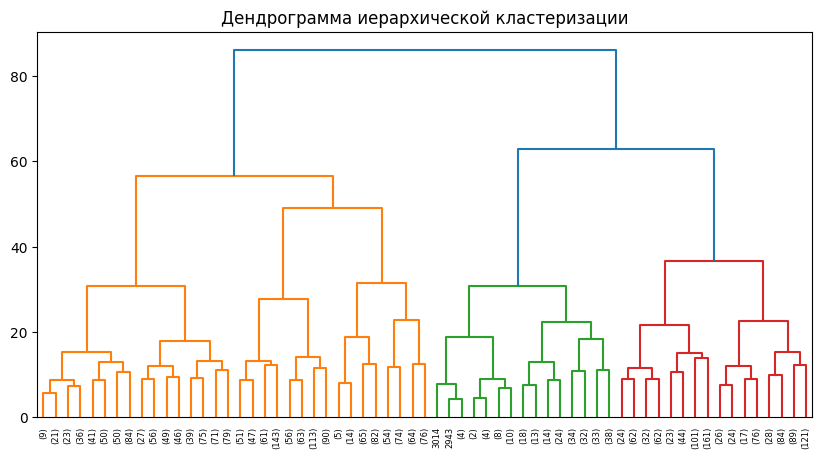

               transaction_amount  num_items  time_on_site_sec  hour_of_day  \
cluster_agglo                                                                 
0                       -0.216686   0.537046          0.188564    -0.000115   
1                       -0.179949  -1.046182         -0.197619     0.009213   
2                        2.408216   0.189743         -0.633789    -0.037138   

               account_age_days     Fraud  device_type_Mobile  \
cluster_agglo                                                   
0                      0.004940  0.027012            0.472437   
1                     -0.003262  0.020534            0.487680   
2                     -0.024513  0.279661            0.453390   

               device_type_Tablet  browser_Edge  browser_Firefox  ...  \
cluster_agglo                                                     ...   
0                        0.081036      0.109702         0.152150  ...   
1                        0.062628      0.099589         0.1

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Считаем linkage для дендрограммы
linked = linkage(df_scaled.drop('Fraud', axis=1), method='ward')

# Строим дендрограмму
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Дендрограмма иерархической кластеризации')
plt.show()

# Обучение модели с выбранным числом кластеров (например, 3)
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')  # affinity убирать!
df_scaled['cluster_agglo'] = agglo.fit_predict(df_scaled.drop('Fraud', axis=1))

# Средние показатели по кластерам
print(df_scaled.groupby('cluster_agglo').mean())


---

Код вычисляет коэффициент силуэта для кластеризации KMeans.
- silhouette_score принимает стандартизированные признаки (без целевой переменной Fraud) и метки кластеров из столбца `cluster`.
- Коэффициент силуэта показывает, насколько объекты внутри кластеров похожи друг на друга и насколько кластеры отделены друг от друга.
- Значение ближе к `1` означает хорошо выраженные кластеры, близкое к `0` — слабое разделение, отрицательное — объекты расположены неправильно.

In [23]:
sil_score = silhouette_score(df_scaled.drop('Fraud', axis=1), df_scaled['cluster'])
print("Silhouette Score:", sil_score)


Silhouette Score: 0.14179065131131274


Значение коэффициента силуэта `0.142` говорит о том, что кластеры выделены слабо.
- Объекты внутри кластеров не очень похожи друг на друга и/или плохо отделены от объектов других кластеров.
- Значение близко к нулю, что указывает на пересечение кластеров или расположение объектов на границах между ними.

---

Этот код вычисляет индекс Калински–Харабаша для оценки качества кластеризации.
- Функция calinski_harabasz_score принимает стандартизированные признаки (без целевой переменной Fraud) и метки кластеров из столбца `cluster`.
- Этот индекс оценивает отношение междукластерной дисперсии к внутрикластерной дисперсии: чем выше значение, тем плотнее и лучше отделены кластеры.

In [22]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(df_scaled.drop('Fraud', axis=1), df_scaled['cluster'])
print("Calinski-Harabasz Score:", ch_score)


Calinski-Harabasz Score: 448.3449243497374


Значение индекса Калински–Харабаша `448.34` указывает на умеренное качество кластеризации.
- Индекс оценивает соотношение между рассеянием между кластерами и рассеянием внутри кластера: чем выше, тем более плотные и разнесённые кластеры.

---

Этот код вычисляет индекс Дэвиса–Боулдина для оценки качества кластеризации.
- Функция davies_bouldin_score принимает стандартизированные признаки (без целевой переменной Fraud) и метки кластеров из столбца `cluster`.
- Индекс измеряет схожесть кластеров, сочетая внутрикластерное рассеяние и расстояния между центрами кластеров.
- Меньшие значения индекса означают лучшее разделение кластеров и более плотные внутри кластеры.

In [24]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(df_scaled.drop('Fraud', axis=1), df_scaled['cluster'])
print("Davies-Bouldin Score:", db_score)


Davies-Bouldin Score: 2.302108784571299


Значение индекса Дэвиса–Боулдина ≈ `2.30` указывает на среднее качество кластеризации.
- Чем меньше значение индекса, тем лучше отделены кластеры и тем плотнее объекты внутри каждого кластера.
- Значение `2.3` показывает, что кластеры не очень плотные и не слишком хорошо различимы, объекты в некоторых кластерах могут быть разрозненными.

---

**Вывод:**

В ходе выполнения лабораторной работы: была изучена и practically применена технология кластеризации данных на примере как синтетического набора, так и реального датасета ecommerce_fraud.csv, содержащего параметры транзакций и метки мошеннической активности. В первой части работы была реализована генерация искусственных данных с тремя заранее заданными кластерами, выполнена их стандартизация и проведена кластеризация методом KMeans. Были построены графические визуализации распределения данных и центров кластеров, а также рассчитан коэффициент силуэта и выполнен анализ разных значений k, что позволило оценить степень выраженности кластерной структуры. На основе графиков и метрик было сделано предположение о наиболее подходящем числе кластеров и проверено качество кластеризации.

Во второй части был использован реальный набор данных, проведено его первичное исследование, проверка на пропуски и дубликаты, кодирование категориальных признаков и стандартизация количественных переменных. Далее были применены методы выбора числа кластеров, включая метод локтя и коэффициент силуэта, что позволило формально обосновать выбор оптимального k. Затем была проведена кластеризация методом KMeans, выполнен анализ средних значений признаков по выделенным кластерам, что позволило интерпретировать их содержательное отличие. Дополнительно была выполнена иерархическая кластеризация с визуализацией дендрограммы, что дало возможность сравнить результаты разных подходов и оценить структуру данных с точки зрения вложенности и степени близости объектов.

На завершающем этапе были рассчитаны основные метрические показатели качества кластеризации — коэффициент силуэта, индекс Калински–Харабаша и индекс Дэвиса–Боулдина. Эти метрики позволили количественно оценить качество полученных кластеров, степень их разделения и компактность. Полученные результаты показали, что кластеризация является эффективным инструментом для структурирования данных даже при отсутствии целевой переменной, а также что предварительная обработка, стандартизация и корректный выбор числа кластеров существенно влияют на итоговое качество алгоритма.